In [ ]:
import pandas as pd 
import numpy as np 
import datetime as dt
import os  
from sklearn.utils import resample

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#!pip install gdown
#!gdown --folder 'https://drive.google.com/drive/folders/1ZvZ670azckL6D8IVxIyiSWOQH70Iv4HO' 

!gdown 'https://drive.google.com/uc?id=1LA6dJJ5tn8oTSWO-Thx2PizItjikfmdP'

#os.getcwd()
#!ls

In [ ]:
#Load Pickled Dataframe from cleaned data stage
crime = pd.read_pickle('/content/crime_final.pkl') 
len(crime)

354515

In [ ]:
#shuffle df prior to split 
np.random.seed(1234)
crime_splits = crime.sample(frac = 1)

#Below we are creating splits for training and test
#70% of our data will be training and validation (60% training, 10% validation), 30% will be test data
split = (0.6,0.3,.1)

#take training split first
crime_train = crime_splits.sample(frac = split[0]) 
crime_splits = crime_splits.drop(crime_train.index)

#scale up test split to account for missing training split
crime_test = crime_splits.sample(frac = split[1]/(1-split[0])) 
crime_splits = crime_splits.drop(crime_test.index)

#residual goes to validation 
crime_validation = crime_splits

#double check the lengths  
print('Training Data Shape', crime_train.shape)
print('Validation Data Shape', crime_validation.shape)
print('Test Data Shape', crime_test.shape)

Training Data Shape (212709, 1736)
Validation Data Shape (35452, 1736)
Test Data Shape (106354, 1736)


In [ ]:
#There is a large class imbalance in our data
print("This is counts of our data before upsampling \n", crime_train['force_outcome'].value_counts()) 
#as a result upsampling of our minority class is required for training data
crime_train_majority = crime_train[crime_train['force_outcome']==0]
crime_train_minority = crime_train[crime_train['force_outcome']!=0] 
print("The Length of the majority class is", len(crime_train_majority)) 
print("The Length of the minority class is", len(crime_train_minority)) 

sample_dif = len(crime_train_majority) - len(crime_train_minority)

# Upsample minority class
crime_train_upsampled = resample(crime_train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=sample_dif,    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
crime_train = pd.concat([crime_train_majority.copy(), crime_train_upsampled.copy()]).sample(frac = 1)

print("This is counts of our data after upsampling \n", crime_train['force_outcome'].value_counts())  

#Delete temp dataframes to perserve memory 
del crime_train_majority, crime_train_minority

This is counts of our data before upsampling 
 0    203970
1      5241
2      3471
3        27
Name: force_outcome, dtype: int64
The Length of the majority class is 203970
The Length of the minority class is 8739
This is counts of our data after upsampling 
 0    203970
1    117111
2     77496
3       624
Name: force_outcome, dtype: int64


In [ ]:
#Convert train test split to numpy for learning

#set y as our outcome variable, or the force_outcome column 
y_train = crime_train['force_outcome'].values
y_test =  crime_test['force_outcome'].values
y_validation =  crime_validation['force_outcome'].values

#set X as our features data, or all columns except the force_outcome column 
X_train = crime_train.loc[:, crime.columns != 'force_outcome'].values
X_test = crime_test.loc[:, crime.columns != 'force_outcome'].values
X_validation = crime_validation.loc[:, crime.columns != 'force_outcome'].values

#Double check results 
print('Size of X_train', X_train.shape)
print('Size of y_train', y_train.shape)
print('Size of X_test', X_test.shape)
print('Size of y_test', y_test.shape)
print('Size of X_validation', X_validation.shape)
print('Size of y_validation', y_validation.shape)


Size of X_train (212709, 1735)
Size of y_train (212709,)
Size of X_test (106354, 1735)
Size of y_test (106354,)
Size of X_validation (35452, 1735)
Size of y_validation (35452,)


In [ ]:
#Save Dataframes for use in model building
np.save('/content/data/X_train.npy', X_train)
np.save('/content/data/y_train.npy', y_train)
np.save('/content/data/X_test.npy', X_test)
np.save('/content/data/y_test.npy', y_test)
np.save('/content/data/X_validation.npy', X_validation)
np.save('/content/data/y_validation.npy', y_validation)

In [ ]:
#DELETE

# added pip install (not present in Kory's notebook)
!pip install --quiet optuna
!pip install --quiet shap
!pip install --quiet gdown

import pandas as pd
import numpy as np
import random
import os 
import optuna


import tensorflow as tf 
from keras import models
from keras import layers
from tensorflow.keras import initializers

# shap
import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
#Load Training and Test sets  
X_train = np.load('/content/data/X_train.npy') 
X_test = np.load('/content/data/X_test.npy') 
X_validation = np.load('/content/data/X_validation.npy') 
y_train = np.load('/content/data/y_train.npy') 
y_test = np.load('/content/data/y_test.npy') 
y_validation = np.load('/content/data/y_validation.npy') 

In [ ]:
#Get the Number of Features in our Model for Input Layer
input_length = X_train.shape[1]
print("The Number of Features in the training data is", input_length) 

#Calculate the number of classes for outcomes for output layer
ouput_legnth = len(np.unique(y_train, return_counts=False))
print("The Number of classes in our output data is", ouput_legnth)

The Number of Features in the training data is 1735
The Number of classes in our output data is 4


In [ ]:
def objective(trial):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    #Create input layer that matches the shape of the number of features
    input1 = tf.keras.layers.Input(shape=(input_length,), name='Input')

    #Creating First Hidden Layer with half number of features as units
    conv1_activation = trial.suggest_categorical("conv1_activation", ["relu", "tanh"])
    input2 = tf.keras.layers.Dense(units=24, activation= conv1_activation, name='Hidden_Layer_1')(input1)

    #Creating Second Hidden Layer with quarter number of features as units 
    conv2_activation = trial.suggest_categorical("conv2_activation", ["relu", "tanh"])
    input3 = tf.keras.layers.Dense(units=24, activation=conv2_activation, name='Hidden_Layer_2')(input2)
    
    conv3_activation = trial.suggest_categorical("conv3_activation", ["relu", "tanh"])
    #Creating Second Hidden Layer with quarter number of features as units   
    input4 = tf.keras.layers.Dense(units=24, activation=conv3_activation, name='Hidden_Layer_3')(input3)
    
    conv4_activation = trial.suggest_categorical("conv4_activation", ["relu", "tanh"])
    #Creating Second Hidden Layer with quarter number of features as units   
    input5 = tf.keras.layers.Dense(units=24, activation=conv4_activation, name='Hidden_Layer_4')(input4)
    
    conv5_activation = trial.suggest_categorical("conv5_activation", ["relu", "tanh"])
    #Creating Second Hidden Layer with quarter number of features as units   
    input6 = tf.keras.layers.Dense(units=24, activation=conv5_activation, name='Hidden_Layer_5')(input5)


    #Adding Dropout Layer for Regurlization 
    #Dropout layer randomly zeros nodes to reduce overfitting 
    input7 = tf.keras.layers.Dropout(rate=0.3, name='Dropout_2')(input6)

    #Create Final Output Layer 
    #Use Bias term
    #Use Softmax because multiclassification problem 
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    output = tf.keras.layers.Dense(
              units=ouput_legnth,
              use_bias=True,
              activation='softmax', 
              kernel_initializer=initializers.RandomNormal(stddev=0.01),
              bias_initializer=initializers.RandomNormal(stddev=0.01),
              name='Output'
        )(input7)

    # instantiate the model
    model = tf.keras.models.Model(inputs=input1, outputs=output)

    #Compile Model
    #SparseCategoricalCrossentropy loss for multiclass problem
    #optimizer = create_optimizer(trial)
    # model.compile(
    #         loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    #         optimizer='Adam',
    #         metrics=['accuracy']
    #     )
    # model.fit(x=X_train,
    #             y=y_train,
    #             batch_size = 200,
    #             validation_data=(X_validation, y_validation),
    #             epochs=10)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizer = create_optimizer(trial)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
    
    hist= model.fit(x=X_train,
                y=y_train,
                batch_size = 100,
                validation_data=(X_validation, y_validation),
                epochs=10
)
    
    hist = hist.history
    accuracy = hist['val_accuracy'][-1]
    return accuracy 

In [ ]:
def create_optimizer(trial):
    optimizer_name = trial.suggest_categorical("optimizer", ["RMSprop", "Adam", "SGD"])
    if optimizer_name == "RMSprop":
        lrn_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        return tf.keras.optimizers.RMSprop(learning_rate=lrn_rate)
    elif optimizer_name == "Adam":
        lrn_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        return tf.keras.optimizers.Adam(learning_rate=lrn_rate)
    else:
        lrn_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        momentum = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)
        return tf.keras.optimizers.SGD(learning_rate=lrn_rate, momentum=momentum)

In [ ]:
study = optuna.create_study(direction='maximize')
results = study.optimize(objective, n_trials=20)
print()

In [ ]:
# Decision Tree with Random Forest

# Install TF-DF
!pip install --quiet tensorflow tensorflow_decision_forests

import tensorflow_decision_forests as tfdf
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

In [ ]:
# define the target column and create TensorFlow datasets
#target = 'force_outcome'
#train_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label=target, task=tfdf.keras.Task.REGRESSION)
#test_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, label=target, task=tfdf.keras.Task.REGRESSION)

train_tfds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_tfds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 100
train_tfds = train_tfds.batch(BATCH_SIZE)
test_tfds = test_tfds.batch(BATCH_SIZE) 

In [ ]:
# instantiate the model
model_rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

# optional step - add evaluation metrics
model_rf.compile(metrics=["mse", "mape"])

# fit the model
# "sys_pipes" is optional and it enables the display of the training logs
with sys_pipes():
  model_rf.fit(x=train_tfds)

Use /tmp/tmpw54jpzwp as temporary training directory
Reading training dataset...


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:01:07.899860. Found 399201 examples.
Training model...


[INFO 2023-03-29T02:01:03.76811158+00:00 kernel.cc:1214] Loading model from path /tmp/tmpw54jpzwp/model/ with prefix d5823b360a0b4be3
[INFO 2023-03-29T02:01:04.240004518+00:00 decision_forest.cc:661] Model loaded with 171 root(s), 140829 node(s), and 562 input feature(s).
[INFO 2023-03-29T02:01:04.240275279+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-03-29T02:01:04.241616263+00:00 kernel.cc:1046] Use fast generic engine


Model trained in 2:09:59.459998
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [ ]:
evaluation = model_rf.evaluate(test_tfds, return_dict=True)

print(evaluation)
print(f"MSE: {evaluation['mse']:.2f}")
print(f"RMSE: {math.sqrt(evaluation['mse']):.2f}")
print(f"MAPE: {evaluation['mape']:.2f}")

1064/1064 [==============================] - 21s 12ms/step - loss: 0.0000e+00 - mse: 0.0120 - mape: 18248876.0000
{'loss': 0.0, 'mse': 0.012041096575558186, 'mape': 18248876.0}
MSE: 0.01
RMSE: 0.11
MAPE: 18248876.00


In [ ]:
# plot the first tree, restricted to depth of 3
tfdf.model_plotter.plot_model_in_colab(model_rf, tree_idx=0, max_depth=3)

In [ ]:
# inspect the features used in the model
model_rf.make_inspector().features()

["data:0.0" (1; #1),
 "data:0.1" (1; #2),
 "data:0.10" (1; #3),
 "data:0.100" (1; #4),
 "data:0.1000" (1; #5),
 "data:0.1001" (1; #6),
 "data:0.1002" (1; #7),
 "data:0.1003" (1; #8),
 "data:0.1004" (1; #9),
 "data:0.1005" (1; #10),
 "data:0.1006" (1; #11),
 "data:0.1007" (1; #12),
 "data:0.1008" (1; #13),
 "data:0.1009" (1; #14),
 "data:0.101" (1; #15),
 "data:0.1010" (1; #16),
 "data:0.1011" (1; #17),
 "data:0.1012" (1; #18),
 "data:0.1013" (1; #19),
 "data:0.1014" (1; #20),
 "data:0.1015" (1; #21),
 "data:0.1016" (1; #22),
 "data:0.1017" (1; #23),
 "data:0.1018" (1; #24),
 "data:0.1019" (1; #25),
 "data:0.102" (1; #26),
 "data:0.1020" (1; #27),
 "data:0.1021" (1; #28),
 "data:0.1022" (1; #29),
 "data:0.1023" (1; #30),
 "data:0.1024" (1; #31),
 "data:0.1025" (1; #32),
 "data:0.1026" (1; #33),
 "data:0.1027" (1; #34),
 "data:0.1028" (1; #35),
 "data:0.1029" (1; #36),
 "data:0.103" (1; #37),
 "data:0.1030" (1; #38),
 "data:0.1031" (1; #39),
 "data:0.1032" (1; #40),
 "data:0.1033" (1; #4

In [ ]:
# get the out-of-bag score
model_rf.make_inspector().evaluation()

Evaluation(num_examples=399201, accuracy=None, loss=None, rmse=0.2202183498031296, ndcg=None, aucs=None, auuc=None, qini=None)

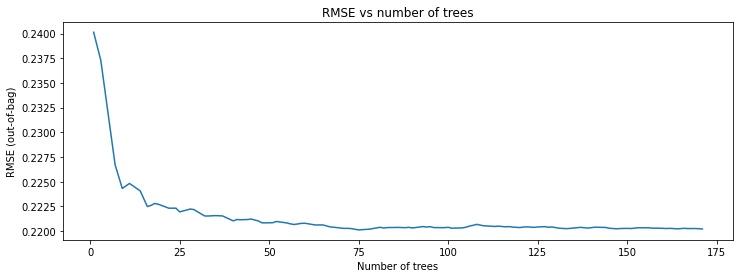

In [ ]:
# plot the RMSE during training 
logs = model_rf.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.title("RMSE vs number of trees")

plt.show()

In [ ]:
pd.set_option('display.max_columns', 2500)
crime.head()

officer_cit_certified_ind_binary  arrest_indicator_binary  \
0                                 1                        0   
1                                 1                        0   
2                                 0                        0   
3                                 1                        0   
4                                 1                        0   

   cit_officer_arrived_ind_binary  cit_officer_dispatched_ind_binary  \
0                               0                                  0   
1                               0                                  0   
2                               0                                  0   
3                               0                                  0   
4                               0                                  0   

   bodycam_ind_binary  military_experience_ind_binary  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   

   subject_juvenile_status_binary  subject_military_ind_binary  \
0                               0                            0   
1                               0                            0   
2                               0                            0   
3                               0                            0   
4                               0                            0   

   dashcam_ind_binary  total_service_time_(s)_standard  \
0                   0                        -0.337544   
1                   0                        -0.435884   
2                   0                         2.254510   
3                   0                         0.688783   
4                   0                         0.688783   

   years_of_experience_standard  officer_age_standard  subject_age_standard  \
0                 -6.964319e-01         -3.978331e-15         -3.978331e-15   
1                 -5.792485e-01         -3.978331e-15         -3.978331e-15   
2                  1.482095e-13         -3.978331e-15         -3.978331e-15   
3                 -2.276985e-01         -3.978331e-15         -3.978331e-15   
4                 -2.276985e-01         -3.978331e-15         -3.978331e-15   

   total_service_time_(seconds)_standard  \
0                          -3.978331e-15   
1                          -3.978331e-15   
2                          -3.978331e-15   
3                          -3.978331e-15   
4                          -3.978331e-15   

   category_call_priority_code_1_priority  \
0                               -0.524460   
1                                1.906716   
2                               -0.524460   
3                                1.906716   
4                                1.906716   

   category_call_priority_code_2_priority  \
0                               -0.686955   
1                               -0.686955   
2                               -0.686955   
3                               -0.686955   
4                               -0.686955   

   category_call_priority_code_3_priority  \
0                               -0.590993   
1                               -0.590993   
2                               -0.590993   
3                               -0.590993   
4                               -0.590993   

   category_call_priority_code_4_priority  \
0                               -0.137263   
1                               -0.137263   
2                                7.285241   
3                               -0.137263   
4                               -0.137263   

   category_call_priority_code_5_priority  \
0                               -0.212754   
1                               -0.212754   
2                               -0.212754   
3                               -0.212754   
4                               -0.212754   

 